# SHRED for ROMs: forecasting

We first randomly select 3 sensor locations and set the trajectory length (lags) to 52, which is hyperparameter tuned.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, rcParams
import pickle
import pandas as pd

plt.rcParams.update({
  "text.usetex": True,
  "font.family": "serif"
})

rcParams['text.latex.preamble'] = r'\usepackage{amssymb} \usepackage{amsmath} \usepackage{amsthm} \usepackage{mathtools}'

var_names, is_vector, times = pickle.load(open('msfr_uloff.set', 'rb'))

path_svd = './OfflineSVD/'
u_total = pickle.load(open(path_svd+'u_total.svd', 'rb'))
v_total = pickle.load(open(path_svd+'v_total.svd', 'rb'))
s_total = pickle.load(open(path_svd+'s_total.svd', 'rb'))

var_names = pickle.load(open(path_svd+"var.names", 'rb'))
rescaling_snaps = pickle.load(open(path_svd+"rescaling.svd", 'rb'))

incore_measure = False
if incore_measure:
  print('Incore measures')
  measurements = pickle.load(open(path_svd+'measurements_incore.data', 'rb'))
else:
  measurements = pickle.load(open(path_svd+'measurements.data', 'rb'))

Let us extract the number of modes

In [2]:
Nmodes = s_total[var_names[0]].shape[0]
Nvariables = len(var_names)
n_configurations = measurements['location'].shape[1]
num_sensors = measurements['noisy_output'].shape[0]

assert measurements['noisy_output'].shape[2] == n_configurations

Ns = measurements['noisy_output'].shape[1]
new_t = np.linspace(times[0], times[-1], Ns)

Let us define the tex variables

In [3]:
energy_groups = 6
tex_var_names = [r'\phi_'+str(g+1) for g in range(energy_groups)]

prec_groups = 8
tex_var_names.extend([r'c_'+str(g+1) for g in range(prec_groups)])

dec_groups = 3
tex_var_names.extend([r'd_'+str(g+1) for g in range(dec_groups)])

tex_var_names.extend(['T', 'p', r'\mathbf{u}'])

assert len(tex_var_names) == len(var_names)

Here the necessary packages for SHRED are loaded

In [4]:
import sys

sys.path.append('../NuSHRED/')

from IPython.display import clear_output
from shred.processdata import load_data
from shred.processdata import TimeSeriesDataset
import shred.models as models
import torch
from sklearn.preprocessing import MinMaxScaler
import os

if incore_measure:
    path_shred = './SHRED_Forecaster/InCore/'
else:
    path_shred = './SHRED_Forecaster/'
if not os.path.exists(path_shred):
    os.makedirs(path_shred)

## Training the SHRED models
For each sensor, a SHRED net is trained

In [5]:
lags = 25 # Default 52
_load_X = v_total.T
sensor_locations = [0,1,2]

shred = list()
train_datasets = list()
valid_datasets = list()
test_datasets  = list()

train_net = True

################################################################################################################

for kk in range(n_configurations):
    
    print('Training SHRED - configuration '+str(kk+1)+'/'+str(n_configurations))

    # Creating input data
    Xsensor = measurements['noisy_output']
    load_X = np.hstack((Xsensor[:,:,kk].T,_load_X))

    m = load_X.shape[1]
    assert m == Nmodes * Nvariables + num_sensors
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    shred.append(models.SHRED(num_sensors, m, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.1).to(device))

    if train_net:
        # # Reconstruction - splitting into train, test and validation
        # train_indices = np.random.choice(Ns - lags, size=500, replace=False)
        # mask = np.ones(Ns - lags)
        # mask[train_indices] = 0
        # valid_test_indices = np.arange(0, Ns - lags)[np.where(mask!=0)[0]]
        # valid_indices = valid_test_indices[::2]
        # test_indices = valid_test_indices[1::2]

        # Forecasting - splitting into train, test and validation
        train_percentage = 0.8
        train_indices = np.arange(0, int(Ns*train_percentage))
        valid_indices = np.arange(int(Ns*train_percentage), int(Ns*train_percentage) + 50)
        test_indices = np.arange(int(Ns*train_percentage) + 50, Ns - lags)
        
        # sklearn's MinMaxScaler is used to preprocess the data for training and we generate input/output pairs for the training, validation, and test sets. 
        sc = MinMaxScaler()
        sc = sc.fit(load_X[train_indices])
        transformed_X = sc.transform(load_X)

        ### Generate input sequences to a SHRED model
        all_data_in = np.zeros((Ns - lags, lags, num_sensors))
        for i in range(len(all_data_in)):
            all_data_in[i] = transformed_X[i:i+lags, sensor_locations]

        ### Generate training validation and test datasets both for reconstruction of states and forecasting sensors
        train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
        valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
        test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

        ### -1 to have output be at the same time as final sensor measurements
        train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
        valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
        test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)

        train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
        valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
        test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

        ### Store the test_datasets for later use
        train_datasets.append({'X': train_dataset.X, 'Y': train_dataset.Y, 'idx': train_indices})
        valid_datasets.append({'X': valid_dataset.X, 'Y': valid_dataset.Y, 'idx': valid_indices})
        test_datasets.append({'X': test_dataset.X, 'Y': test_dataset.Y, 'idx': test_indices})

        validation_errors = models.fit(shred[kk], train_dataset, valid_dataset, batch_size=64, num_epochs=3000, lr=1e-3, verbose=False, patience=5)
        torch.save(shred[kk].state_dict(), path_shred+'trained_svd'+str(Nmodes)+'_config'+str(kk)+'_measuring_'+var_names[measurements['measured_field']]+'.shred')
        pickle.dump(test_datasets, open(path_shred+'datasets.test', 'wb'))
    else:
        shred[kk].load_state_dict(torch.load(path_shred+'trained_svd'+str(Nmodes)+'_config'+str(kk)+'_measuring_'+var_names[measurements['measured_field']]+'.shred'))
        test_datasets = pickle.load(open(path_shred+'datasets.test', 'rb'))

Training SHRED - configuration 1/30


/home/paolo/miniconda3/envs/mp/lib/python3.10/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


Training SHRED - configuration 2/30
Training SHRED - configuration 3/30
Training SHRED - configuration 4/30
Training SHRED - configuration 5/30
Training SHRED - configuration 6/30
Training SHRED - configuration 7/30
Training SHRED - configuration 8/30
Training SHRED - configuration 9/30
Training SHRED - configuration 10/30
Training SHRED - configuration 11/30
Training SHRED - configuration 12/30
Training SHRED - configuration 13/30
Training SHRED - configuration 14/30
Training SHRED - configuration 15/30
Training SHRED - configuration 16/30
Training SHRED - configuration 17/30
Training SHRED - configuration 18/30
Training SHRED - configuration 19/30
Training SHRED - configuration 20/30
Training SHRED - configuration 21/30
Training SHRED - configuration 22/30
Training SHRED - configuration 23/30
Training SHRED - configuration 24/30
Training SHRED - configuration 25/30
Training SHRED - configuration 26/30
Training SHRED - configuration 27/30
Training SHRED - configuration 28/30
Training 

Finally, we generate reconstructions from the test set and print mean square error compared to the ground truth.

In [6]:
if incore_measure:
    path_test = './Test_results_Forecaster/InCore/'
else:
    path_test = './Test_results_Forecaster/'
    
if not os.path.exists(path_test):
    os.makedirs(path_test)  

if train_net:
    test_recons = list()
    test_ground_truth = list()

    relative_test_errors = list()

    for kk in range(n_configurations):
        test_recons.append(sc.inverse_transform(shred[kk](test_datasets[kk]['X']).detach().cpu().numpy()))
        test_ground_truth.append(sc.inverse_transform(test_datasets[kk]['Y'].detach().cpu().numpy()))
        
        relative_test_errors.append(np.linalg.norm(test_recons[kk] - test_ground_truth[kk]) / np.linalg.norm(test_ground_truth[kk]))
        
    pickle.dump([test_recons, test_ground_truth, relative_test_errors], open(path_test+'test.results', 'wb'))
else:
    test_recons, test_ground_truth, relative_test_errors = pickle.load(open(path_test+'test.results', 'rb'))

Let us plot the error bars

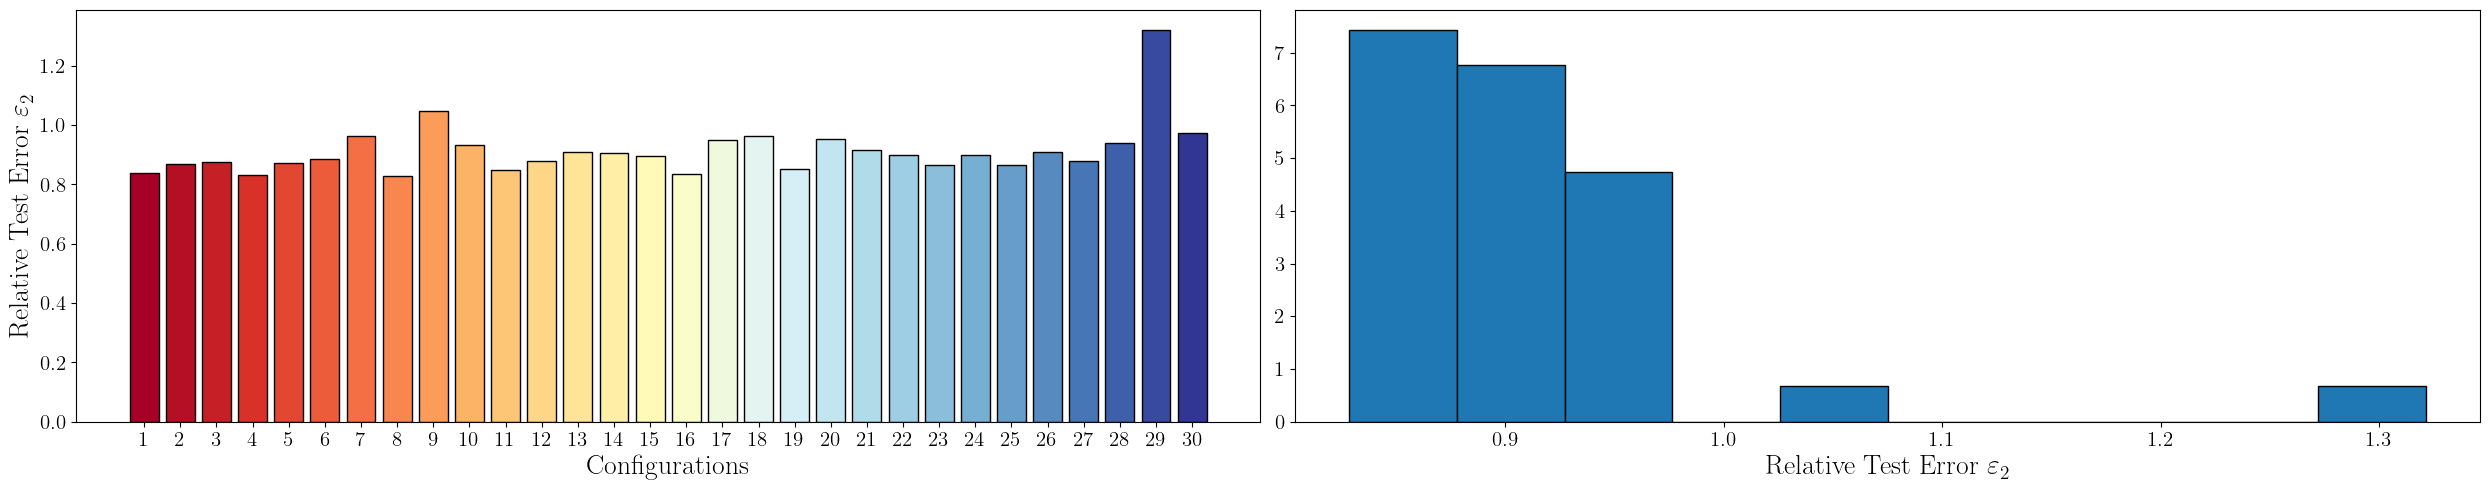

In [7]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(25,5))

# Bars
axs[0].bar(np.arange(1, n_configurations+1, 1), relative_test_errors, 
        color = cm.RdYlBu(np.linspace(0,1,len(relative_test_errors))),
        edgecolor='k')

axs[0].set_xticks(np.arange(1, n_configurations+1, 1))
axs[0].set_xlabel(r'Configurations', fontsize=20)
axs[0].set_ylabel(r'Relative Test Error $\varepsilon_{2}$', fontsize=20)

# Histogram
axs[1].hist(relative_test_errors, edgecolor='k', density=True)
axs[1].set_xlabel(r'Relative Test Error $\varepsilon_{2}$', fontsize=20)

[ax.tick_params(axis='both', labelsize=15) for ax in axs]

plt.tight_layout()

### Uncertainty Quantification

Let us plot the output of the SHRED networks considering their mean and standard deviation

In [8]:
from pyforce.tools.backends import LoopProgress

bar = LoopProgress('Plotting SHRED Output UQ', len(var_names))

for field_i in range(len(var_names)):

    nrows = 2
    ncols = 5
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(6 * ncols, 5 * nrows))
    axs = axs.flatten()

    colors = cm.jet([0.1, 0.25, 0.9])
    ls = 2

    for rr in range(Nmodes):
        
        mode = field_i * Nmodes + rr
        
        ground_truth_values = []
        ground_truth_values.extend(sc.inverse_transform(train_dataset.Y.detach().cpu().numpy())[:, mode+3])
        ground_truth_values.extend(sc.inverse_transform(valid_dataset.Y.detach().cpu().numpy())[:, mode+3])
        ground_truth_values.extend(sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())[:, mode+3])
        
        numpy_shred_values = np.zeros((len(new_t) - lags, n_configurations))
        for kk in range(n_configurations):
            shred_values = []
            shred_values.extend(sc.inverse_transform(shred[kk](train_datasets[kk]['X']).detach().cpu().numpy())[:, mode+3])
            shred_values.extend(sc.inverse_transform(shred[kk](valid_datasets[kk]['X']).detach().cpu().numpy())[:, mode+3])
            shred_values.extend(sc.inverse_transform(shred[kk](test_datasets[kk]['X']).detach().cpu().numpy())[:, mode+3])
            numpy_shred_values[:,kk] = shred_values
        
        axs[rr].fill_between(new_t[train_indices], -10, 10,
                             color = cm.cool(10), alpha=0.2, label='Train')
        axs[rr].fill_between(new_t[valid_indices], -10, 10,
                             color = cm.cool(250), alpha=0.2, label='Validation')
        axs[rr].fill_between(new_t[test_indices], -10, 10,
                             color = cm.cool(120), alpha=0.2, label='Test')
        
        axs[rr].plot(new_t[:len(new_t) - lags], numpy_shred_values.mean(axis=1), c=colors[0], label=r'Mean SHRED', linewidth=ls)
        axs[rr].fill_between(new_t[:len(new_t) - lags], 
                             numpy_shred_values.mean(axis=1) - 1.96 * numpy_shred_values.std(axis=1),
                             numpy_shred_values.mean(axis=1) + 1.96 * numpy_shred_values.std(axis=1),
                             color=cm.jet(0.1), alpha=0.25, linewidth=ls, label=r'Confidence Interval SHRED')
        
        axs[rr].plot(new_t[:len(new_t) - lags], ground_truth_values, '--', c=colors[2], label=r'Ground Truth', linewidth=ls)
        
        axs[rr].set_ylabel(r'$v_{'+str(rr+1)+'}^{'+tex_var_names[field_i]+r'}$', fontsize=20)
        axs[rr].grid()

        axs[rr].set_xlim(min(times), max(new_t[test_indices]))
        # axs[rr].set_xlim(15, max(new_t[test_indices]))
        
        clim_scale = 0.05
        if min(ground_truth_values) < 0:
            ymin = min(ground_truth_values) * (1+clim_scale)
        else:
            ymin = min(ground_truth_values) * (1-clim_scale)
            
        if max(ground_truth_values) < 0:
            ymax = max(ground_truth_values) * (1-clim_scale)
        else:
            ymax = max(ground_truth_values) * (1+clim_scale)
        
        axs[rr].set_ylim(ymin, ymax)
        
        axs[rr].tick_params(axis='both', labelsize=15)

    Line, Label = axs[0].get_legend_handles_labels()
    fig.legend(Line, Label, fontsize=25, ncols=6, framealpha=1, loc=(0.1, 0.9325))

    axs = axs.reshape(nrows, ncols)
    [ax.set_xlabel(r'Time $t$ (s)', fontsize=20) for ax in axs[1]]

    fig.subplots_adjust(hspace=0.05, top = 0.925, wspace=0.4)
    fig.savefig(path_test+'SHRED_output_uq_'+var_names[field_i]+'.pdf', format='pdf', dpi=250, bbox_inches='tight')
    plt.close(fig)

    bar.update(1)

Plotting SHRED Output UQ: 20.000 / 20.00 - 15.002 s/it


Let us plot the first 5 temporal dynamical the reduced coefficients for each field

In [9]:
# modes_to_plot = 5
    
# nrows = 4
# ncols = 5
# fig, axs = plt.subplots(nrows = nrows, ncols=ncols, sharex=True, sharey=True, figsize=(6 * ncols, 5 * nrows))
# axs = axs.flatten()

# ls = 2

# for field_i, field in enumerate(var_names):

#     idx_to_plot = np.arange(field_i * Nmodes,
#                             modes_to_plot + field_i * Nmodes,
#                             1, 
#                             dtype=int)

#     colors = cm.plasma(np.linspace(0.05,0.95,len(idx_to_plot)))
#     colors_gt = cm.viridis(np.linspace(0.05,0.95,len(idx_to_plot)))
#     for ii, idx in enumerate(idx_to_plot):
#         axs[field_i].plot(new_t[test_datasets[-1]['idx']], test_ground_truth[-1][:, idx+3], '-', linewidth=ls, c=colors_gt[-1-ii], label=r'Ground Truth - $r='+str(ii+1)+'$')

#         axs[field_i].plot(binned_stats[idx]['time'], binned_stats[idx]['mean'], '-.', c=colors[ii], label=r'Mean Prediction', linewidth=ls)
#         axs[field_i].fill_between(  binned_stats[idx]['time'], 
#                                     y1 = binned_stats[idx]['mean'] - 1.96 * binned_stats[idx]['std'],
#                                     y2 = binned_stats[idx]['mean'] + 1.96 * binned_stats[idx]['std'],
#                                     color=colors[ii], alpha=0.3, label=r'95\% Confidence Interval')

#     axs[field_i].set_ylabel(r'$v_r^{'+tex_var_names[field_i]+r'}$', fontsize=35)
#     axs[field_i].grid()

#     axs[field_i].set_xticks(np.arange(0,25.0001, 5))
#     axs[field_i].set_xlim(min(times), max(times))
#     axs[field_i].tick_params(axis='both', labelsize=18)
#     # axs[field_i].legend(loc=(1.025, 0.35), ncols=2)
    
# Line, Label = axs[0].get_legend_handles_labels()
# fig.legend(Line, Label, fontsize=22, ncols=5, framealpha=1, loc=(0.075, 0.92))

# axs = axs.reshape(nrows, ncols)
# [ax.set_xlabel(r'Time $t$ (s)', fontsize=25) for ax in axs[-1]]

# fig.subplots_adjust(hspace=0.05, top = 0.915, wspace=0.2)
# fig.savefig(path_test+'SHRED_dynamics_uq.pdf', format='pdf', dpi=250, bbox_inches='tight')

### Decoding to Full Order

In this last section, the output of the SHRED network $\hat{\mathbf{v}}$ is used to estimate the field of interest, using the decoding from the Singular Value Decomposition.

Let us compute the average relative error for generic field $u$ as
\begin{equation*}
\varepsilon_u = \frac{1}{T}\sum_{t=1}^T \frac{\| u_t - \hat{u}_t\|_2}{\| u_t\|_2}
\end{equation*}
given $\hat{u}_t$ the reconstruction at time $t$.

In [10]:
Ns_test = test_recons[0].shape[0]

if train_net:
    ave_rel_errors = np.zeros((Nvariables, Ns_test, n_configurations))

    bar = LoopProgress('Computing relative 2-error', Nvariables)
    for field_i in range(Nvariables):
        
        for kk in range(n_configurations):
            v_truth = test_ground_truth[kk][:, 3 + field_i*Nmodes : 3 + (field_i+1)*Nmodes]
            v_shred = test_recons[kk][:,3 + field_i*Nmodes : 3 + (field_i+1)*Nmodes]

            u_ = u_total[var_names[field_i]]
            s_ = np.diag(s_total[var_names[field_i]])

            fom = (u_ @ s_ @ v_truth.T) * rescaling_snaps[field_i]
            prediction = (u_ @ s_ @ v_shred.T) * rescaling_snaps[field_i]
            
            ave_rel_errors[field_i, :, kk] = np.linalg.norm(fom - prediction, axis=0) / np.linalg.norm(fom, axis=0)
            
        bar.update(1)
    
    pickle.dump(ave_rel_errors, open(path_test+'fom.errors', 'wb'))
    
else:
    ave_rel_errors = pickle.load(open(path_test+'fom.errors', 'rb'))

Computing relative 2-error: 20.000 / 20.00 - 10.374 s/it


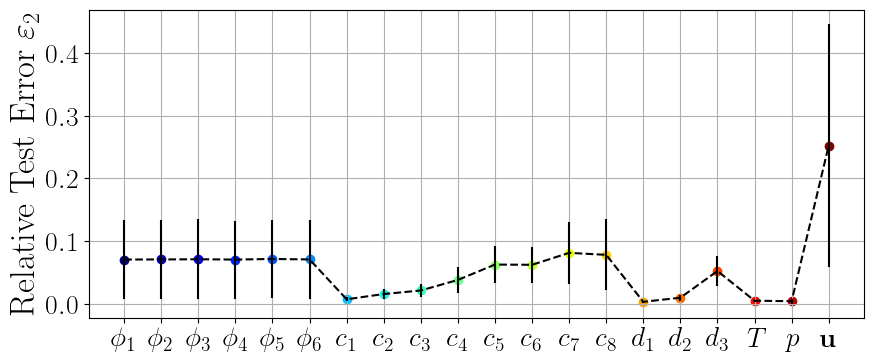

In [11]:
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize=(10,4))

axs.errorbar(np.arange(0,len(var_names),1), np.mean(ave_rel_errors.mean(axis=1), axis=1), np.std(ave_rel_errors.mean(axis=1), axis=1), fmt='--', color='k')

colors = cm.jet(np.linspace(0,1, len(var_names)))
for field_i in range(len(var_names)):
    axs.scatter(field_i , np.mean(ave_rel_errors.mean(axis=1), axis=1)[field_i], color=colors[field_i])

axs.set_xticks(np.arange(0,len(var_names),1), ['$'+tex_+'$' for tex_ in tex_var_names])

axs.tick_params(axis='both', labelsize=20)
axs.set_ylabel(r'Relative Test Error $\varepsilon_{2}$', fontsize=25)
axs.grid()

fig.savefig(path_test+'fom_relativerrror_bars.pdf', format='pdf', dpi=250, bbox_inches='tight')

# Code for bar plot
# fig = plt.figure(figsize=(6, 4))

# skip = 2
# num_bars = ave_rel_errors.shape[0]
# bar_colors = plt.cm.viridis(np.linspace(0, 1, num_bars))  # Generate a color map based on the number of bars

# histo = plt.bar(np.arange(1, skip*(ave_rel_errors.shape[0]), skip), 
#         np.mean(ave_rel_errors, axis=1), color=bar_colors)
# plt.xticks(np.arange(1, skip*(ave_rel_errors.shape[0]), skip), ['$'+tex+'$' for tex in tex_var_names])
# # plt.xticks(np.arange(1, skip*(ave_rel_errors.shape[0]), skip), np.arange(0, ave_rel_errors.shape[0], 1))

# # plt.yscale('log')
# plt.grid()

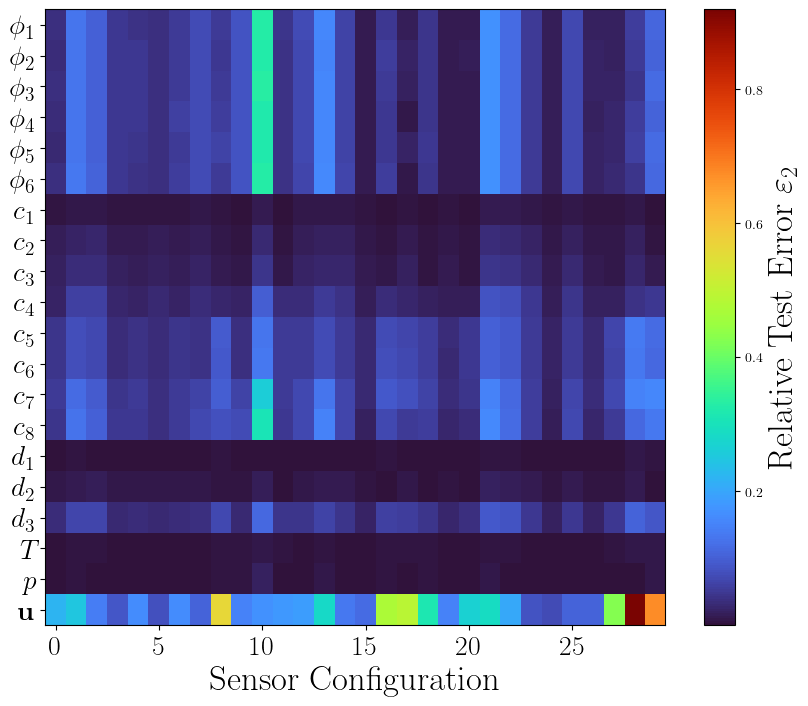

In [12]:
fig, axs = plt.subplots(figsize=(10,8))

heat_map = axs.imshow(ave_rel_errors.mean(axis=1), cmap=cm.turbo, aspect='auto')

axs.set_xlabel(r'Sensor Configuration', fontsize=25)
axs.set_yticks(np.arange(len(var_names)), labels=['$'+tex_+'$' for tex_ in tex_var_names])
axs.tick_params(axis='both', labelsize=20)
cbar = plt.colorbar(heat_map)
cbar.set_label(r'Relative Test Error $\varepsilon_{2}$', fontsize=25)

fig.savefig(path_test+'fom_relativerrror_heatmap.pdf', format='pdf', dpi=250, bbox_inches='tight')


# # Loop over data dimensions and create text annotations
# for i in range(len(var_names)):
#     for j in range(n_configurations):
#         text = axs.text(j, i, ave_rel_errors.mean(axis=1)[i, j],
#                        ha="center", va="center", color="w")